# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train,
                  learning_rate=lr, reg=reg,
                  num_iters=200, batch_size=500)

        train_preds = svm.predict(X_train_feats)
        train_acc = (train_preds == y_train).mean()

        val_preds = svm.predict(X_val_feats)
        val_acc = (val_preds == y_val).mean()

        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.110531 val accuracy: 0.116000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.090184 val accuracy: 0.091000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.096306 val accuracy: 0.107000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.125082 val accuracy: 0.106000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.113265 val accuracy: 0.120000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.413020 val accuracy: 0.416000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.096408 val accuracy: 0.097000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.412041 val accuracy: 0.416000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.367143 val accuracy: 0.369000
best validation accuracy achieved during cross-validation: 0.416000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.425


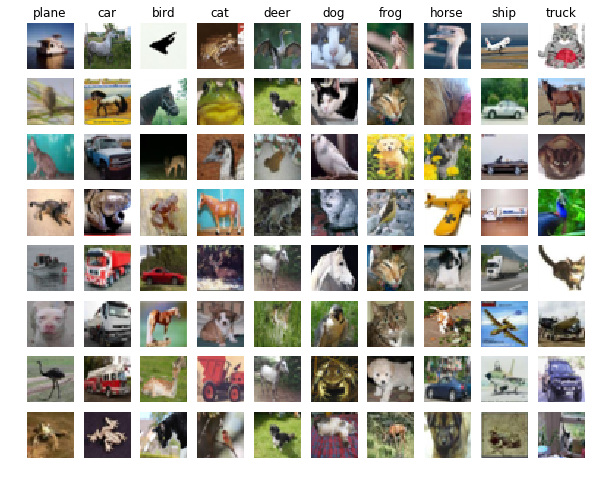

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Those that make sense often display a distinctive feature that is common for a given class. For example, it's a tilted straight line across the image. For a car, that's most probably tires (that's why trucks are mistaken for cars).

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print X_train_feats.shape

(49000, 155)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_val = -1
best_net = None
best_history = None

results = {}

################################################################################
# Train a two-layer neural network on image features. You may want to          #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [5e-1]  # [1e-1, 5e-2]
regularization_strengths = [5e-3]  # [1e-3, 5e-2]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        history = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            learning_rate=lr, reg=reg,
                            learning_rate_decay=0.92,
                            num_iters=1500, batch_size=512)

        train_preds = net.predict(X_train_feats)
        train_acc = (train_preds == y_train).mean()

        val_preds = net.predict(X_val_feats)
        val_acc = (val_preds == y_val).mean()

        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_net = net
            best_history = history
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 5.000000e-01 reg 5.000000e-03 train accuracy: 0.611980 val accuracy: 0.588000
best validation accuracy achieved during cross-validation: 0.588000


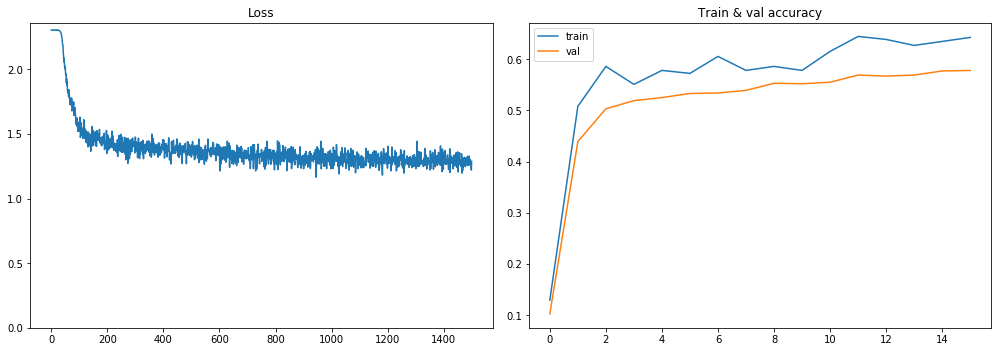

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].set_title("Loss")
axes[0].plot(best_history['loss_history'])
axes[0].set_ylim([0, None])

axes[1].set_title("Train & val accuracy")
p1 = axes[1].plot(best_history['train_acc_history'])
p2 = axes[1].plot(best_history['val_acc_history'])
axes[1].legend((p1[0], p2[0]), ("train", "val"))

plt.tight_layout()

In [10]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.56


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [11]:
def piecewise_color_hist(img, levels=2, n_color_bins=8):
    img_size = 32  # Hardcoded for the sake of brevity
    results = []
    for level in xrange(levels):
        n_parts = 2 ** (level)
        part_size = img_size / n_parts
        for x in xrange(n_parts):
            for y in xrange(n_parts):
                results.append(color_histogram_hsv(img[x:x+part_size, y:y+part_size], nbin=n_color_bins))
    return np.concatenate(results)

It's possible to encode some of the relative position signal by using color histogram or HOG on parts of the image.

Performance (with the same hyperparameter grids):
* `levels=1` — 0.253 (SVM) / 0.286 (2-layer NN) — this function is identical to `color_histogram_hsv`
* `levels=2` — 0.247 (SVM) / 0.301 (2-layer NN)
* `levels=3` — 0.233 (SVM) / 0.304 (2-layer NN)
* `levels=4` — 0.225 (SVM) / 0.318 (2-layer NN)
* `levels=5` — would take too long to compute

The accuracy above was calculated with `learning_rates = [1e-9, 1e-8, 1e-7]` / `regularization_strengths = [1e5, 1e6, 1e7]` for SVM and with `learning_rates = [5e-1]` / `regularization_strengths = [1e-3]` for 2-layer NN.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

Let's calculate the fullest set of additional features.

This implicitly includes `color_histogram_hsv` for the entire image as a part of `piecewise_color_hist` call.

In [12]:
feature_fns = [hog_feature, lambda img: piecewise_color_hist(img, levels=4, n_color_bins=10)]
X_train_feats = extract_features(X_train, feature_fns)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Let's combine raw image pixels and our set of additional features.

In [13]:
X_train_full = np.concatenate((X_train.reshape(X_train.shape[0], -1), X_train_feats), axis=1)
X_val_full = np.concatenate((X_val.reshape(X_val.shape[0], -1), X_val_feats), axis=1)
X_test_full = np.concatenate((X_test.reshape(X_val.shape[0], -1), X_test_feats), axis=1)

And train a neural network on it.

In [14]:
input_dim = X_train_full.shape[1]
hidden_dim = 500
num_classes = 10

best_val = -1
best_net = None
best_history = None

results = {}

learning_rates = [1e-3]  # [10**n for n in np.arange(-8, 2)]
regularization_strengths = [1e0]  # [10**n for n in np.arange(-8, 3)]

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        history = net.train(X_train_full, y_train, X_val_full, y_val,
                            learning_rate=lr, reg=reg,
                            num_iters=2500, batch_size=1024)

        train_preds = net.predict(X_train_full)
        train_acc = (train_preds == y_train).mean()

        val_preds = net.predict(X_val_full)
        val_acc = (val_preds == y_val).mean()

        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_net = net
            best_history = history

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-03 reg 1.000000e+00 train accuracy: 0.484388 val accuracy: 0.471000
best validation accuracy achieved during cross-validation: 0.471000


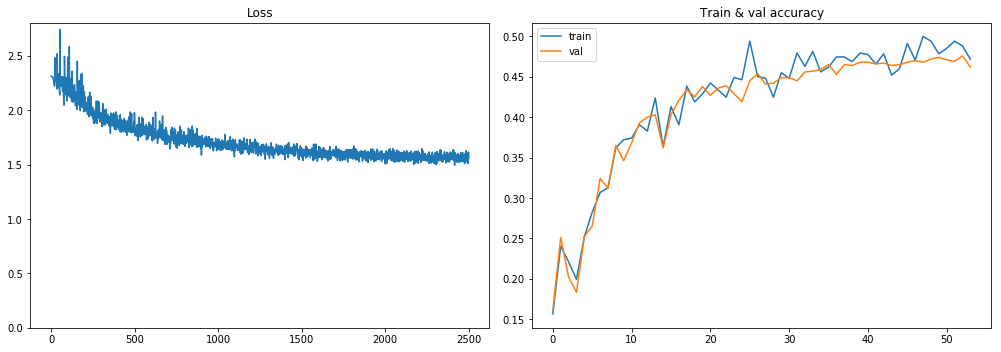

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].set_title("Loss")
axes[0].plot(best_history['loss_history'])
axes[0].set_ylim([0, None])

axes[1].set_title("Train & val accuracy")
p1 = axes[1].plot(best_history['train_acc_history'])
p2 = axes[1].plot(best_history['val_acc_history'])
axes[1].legend((p1[0], p2[0]), ("train", "val"))

plt.tight_layout()

Alas, this works worse somehow. Probably the hyperparameters grid should include more different parameters.

In [16]:
test_acc = (best_net.predict(X_test_full) == y_test).mean()
print test_acc

0.469
